# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
import pickle
import os
import warnings
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

# Load Dataset

In [2]:
df = pd.read_csv("Multimodal_EEG_HAR_Balanced_Final_v2.2.csv")

df

,Ch1_Std,Ch1_RMS,Ch1_Delta,Ch1_Theta,Ch1_Alpha,Ch1_Beta,Ch1_Gamma,Ch2_Std,Ch2_RMS,Ch2_Delta,...,Ch16_Alpha,Ch16_Beta,Ch16_Gamma,Accel X (g),Accel Y (g),Accel Z (g),Gyro X (°/s),Gyro Y (°/s),Gyro Z (°/s),Final_Activity_Label
0,1.171362e+01,1.171455e+01,1.545709e+02,1.136476e+01,1.352785e+00,1.840415e+00,1.897683e+00,1.138528e+02,1.161625e+02,1.276461e+04,...,159.724712,165.395052,161.945130,-7.141904,-2.889801,6.378153,-0.023213,-0.008552,-0.029322,Chair Squats
1,2.585113e-04,2.726944e-04,1.143008e-08,2.023924e-10,3.756345e-12,6.591203e-12,2.423963e-12,2.540486e+02,2.624816e+02,3.391425e+04,...,44.179222,510.635774,4.706429,-0.385466,-2.466028,9.612720,0.020769,-0.094073,0.079412,Chair Squats
2,3.779291e+01,3.772484e+01,5.814354e+02,1.142740e+01,1.991369e+00,1.036174e+02,2.511568e+02,7.059363e+02,7.255588e+02,2.937393e+05,...,29.077823,652.743966,448.898546,3.169923,-5.427655,5.046977,-1.687210,-0.260229,0.002443,Chair Squats
3,1.324673e+02,1.332910e+02,3.896453e+03,4.593790e+02,3.632279e+01,5.620181e+01,6.353971e+01,2.084299e+03,2.177075e+03,7.675029e+05,...,418.305849,1021.006955,1597.588525,3.581726,-0.373495,10.038888,-0.133169,-0.334754,-0.686613,Chair Squats
4,3.679947e-07,3.673028e-07,6.891314e-14,1.376034e-15,2.283754e-17,4.041542e-17,1.487656e-17,1.922527e+03,1.954525e+03,7.602498e+05,...,24.109394,814.032984,7.415880,0.246603,-0.916979,9.756372,0.173486,-0.080634,0.037874,Chair Squats
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24616,1.798222e-08,1.795093e-08,2.721746e-16,9.829382e-18,2.947257e-20,4.538679e-20,1.677551e-20,3.178656e+02,3.237217e+02,2.340773e+04,...,60.886117,1364.060701,20.009147,-2.547430,-0.840365,9.009381,0.039095,0.084299,0.021991,Wall Push-ups
24617,2.386863e-08,2.387259e-08,4.697621e-16,1.929357e-17,4.626635e-20,8.093714e-20,2.982981e-20,1.607020e+02,1.606605e+02,1.361523e+04,...,36.299800,6.947727,4.777935,6.354211,-4.446033,5.861006,-0.018326,0.029322,-0.025656,Wall Push-ups
24618,1.619312e-08,1.672359e-08,1.371260e-16,4.282930e-18,2.274289e-20,3.600709e-20,1.321833e-20,3.252570e-08,3.310586e-08,8.275933e-16,...,24.014193,4.887524,3.170469,-4.113238,-0.577003,8.868123,-0.183260,0.437379,0.124617,Wall Push-ups
24619,1.838436e-08,1.839180e-08,3.543114e-16,7.661932e-18,3.097910e-20,5.423027e-20,1.984990e-20,1.757659e+00,1.817992e+00,1.945646e+00,...,86.728650,42.350096,62.033822,-2.571372,-0.746991,9.308656,0.043982,-0.007330,0.032987,Wall Push-ups


# Label Encoding for Target Variable

In [3]:
LE = LabelEncoder()
df['Final_Activity_Label'] = LE.fit_transform(df['Final_Activity_Label'])

# Feature Selection and Data Preparation

In [4]:
# HAR features (Accelerometer + Gyroscope)
har_features = ['Accel X (g)', 'Accel Y (g)', 'Accel Z (g)',
                'Gyro X (°/s)', 'Gyro Y (°/s)', 'Gyro Z (°/s)']

# EEG features (Top 101 most important features)
eeg_features = [
    'Ch11_Beta', 'Ch9_Beta', 'Ch10_Beta', 'Ch7_Beta', 'Ch16_Beta', 'Ch11_RMS',
    'Ch14_Beta', 'Ch13_Beta', 'Ch11_Std', 'Ch9_Std', 'Ch15_Std', 'Ch10_Std',
    'Ch7_RMS', 'Ch10_Theta', 'Ch15_Beta', 'Ch13_RMS', 'Ch10_Delta', 'Ch11_Delta',
    'Ch16_RMS', 'Ch7_Delta', 'Ch15_RMS', 'Ch10_RMS', 'Ch10_Alpha', 'Ch11_Gamma',
    'Ch9_RMS', 'Ch13_Std', 'Ch11_Alpha', 'Ch14_RMS', 'Ch11_Theta', 'Ch7_Theta',
    'Ch12_Beta', 'Ch6_RMS', 'Ch14_Delta', 'Ch7_Std', 'Ch5_Std', 'Ch6_Std',
    'Ch3_Beta', 'Ch16_Std', 'Ch3_RMS', 'Ch2_Beta', 'Ch8_Std', 'Ch13_Theta',
    'Ch5_RMS', 'Ch13_Gamma', 'Ch15_Delta', 'Ch13_Alpha', 'Ch8_Beta', 'Ch14_Std',
    'Ch7_Alpha', 'Ch6_Beta', 'Ch4_Std', 'Ch10_Gamma', 'Ch8_RMS', 'Ch3_Std',
    'Ch4_RMS', 'Ch13_Delta', 'Ch9_Delta', 'Ch9_Theta', 'Ch5_Delta', 'Ch16_Alpha',
    'Ch6_Delta', 'Ch14_Theta', 'Ch12_Std', 'Ch4_Alpha', 'Ch16_Theta', 'Ch16_Gamma',
    'Ch9_Alpha', 'Ch7_Gamma', 'Ch9_Gamma', 'Ch15_Alpha', 'Ch8_Alpha', 'Ch5_Beta',
    'Ch2_Alpha', 'Ch6_Gamma', 'Ch2_RMS', 'Ch14_Alpha', 'Ch12_Alpha', 'Ch4_Beta',
    'Ch15_Theta', 'Ch12_RMS', 'Ch4_Gamma', 'Ch12_Delta', 'Ch16_Delta', 'Ch12_Gamma',
    'Ch3_Gamma', 'Ch8_Delta', 'Ch6_Alpha', 'Ch3_Delta', 'Ch5_Gamma', 'Ch5_Theta',
    'Ch5_Alpha', 'Ch12_Theta', 'Ch2_Std', 'Ch15_Gamma', 'Ch2_Gamma', 'Ch8_Theta',
    'Ch4_Delta', 'Ch14_Gamma', 'Ch3_Alpha', 'Ch8_Gamma', 'Ch6_Theta'
]

X = df[har_features + eeg_features].values
y = df['Final_Activity_Label'].values

# Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=15, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (17234, 107)
X_test shape: (7387, 107)


# XGBoost Model Training, Evaluation, and Cross-Validation

===== Training and Inference Times =====
Training Time: 4.2824 seconds
Inference Time (for test set): 0.0242 seconds

===== Stratified Cross-Validation Results =====
Stratified CV Accuracy (mean ± std): 0.9938 ± 0.0021
Training Set Accuracy: 1.0000
Test Set Accuracy: 0.9923

===== Classification Report =====
                             precision    recall  f1-score   support

               Chair Squats       0.98      0.99      0.99       686
   Light Stationary Cycling       1.00      0.98      0.99       567
          Marching in Place       1.00      0.99      0.99       763
        Seated Boxing Hooks       0.99      0.99      0.99       742
      Seated Leg Extensions       0.99      1.00      0.99       776
Seated Medicine Ball Twists       0.99      1.00      1.00       763
          Seated Side Bends       1.00      1.00      1.00       806
              Side-Stepping       0.99      0.99      0.99       600
  Standing Heel-to-Toe Walk       0.98      0.99      0.99       821

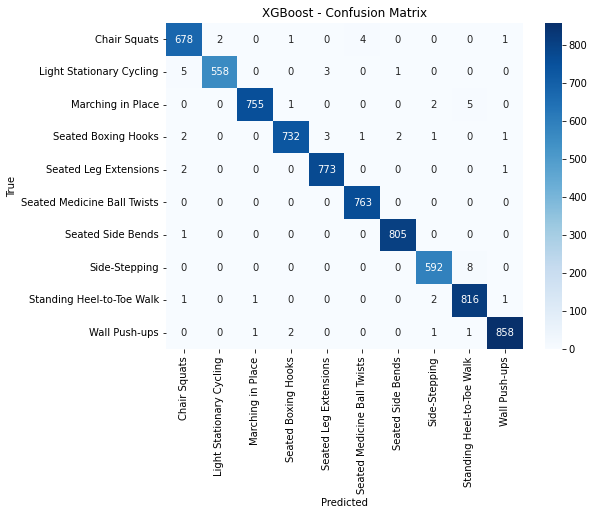

In [6]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===================== Initialize the XGBClassifier with best parameters =====================
XGB = XGBClassifier(
    n_estimators=200,
    learning_rate=0.09661761457749352,  
    max_depth=5, 
    subsample=0.9124217733388136, 
    colsample_bytree=0.7467983561008608,  
    gamma=0.017425083650459836,  
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# ============================ Model Training and Time Measurement ============================
start_train_time = time.time()
XGB.fit(X_train, y_train)
train_time = time.time() - start_train_time

print("===== Training and Inference Times =====")
print(f"Training Time: {train_time:.4f} seconds")

# ============================ Inference and Time Measurement ============================
start_infer_time = time.time()
preds = XGB.predict(X_test)
infer_time = time.time() - start_infer_time

print(f"Inference Time (for test set): {infer_time:.4f} seconds")

# ============================ Accuracy Calculation ============================
train_preds = XGB.predict(X_train)
test_preds = XGB.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

# ============================ Stratified K-Fold Cross-Validation ============================
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(XGB, X_train, y_train, cv=skf, scoring='accuracy')

cv_mean = cross_val_scores.mean()
cv_std = cross_val_scores.std()

# =========================== Combined Results ===========================
print("\n===== Stratified Cross-Validation Results =====")
print(f"Stratified CV Accuracy (mean ± std): {cv_mean:.4f} ± {cv_std:.4f}")
print(f"Training Set Accuracy: {train_acc:.4f}")
print(f"Test Set Accuracy: {test_acc:.4f}")

# ============================ Classification Report ============================
class_names = LE.classes_

print("\n===== Classification Report =====")
print(classification_report(y_test, test_preds, target_names=class_names))

# ============================ Confusion Matrix ============================
conf_matrix = confusion_matrix(y_test, test_preds)
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

print("\n===== Confusion Matrix on Test Set =====")
print(df_conf_matrix)

# ======================= Plot Confusion Matrix ========================
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('XGBoost - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save Trained XGBoost Model

In [7]:
import pickle

with open("XGB_HAR_EEG_Multimodal.pkl", "wb") as file:
    pickle.dump(XGB, file)

print("XGBoost model for HAR & EEG Multimodal has been successfully saved to 'XGB_HAR_EEG_Multimodal.pkl'")

XGBoost model for HAR & EEG Multimodal has been successfully saved to 'XGB_HAR_EEG_Multimodal.pkl'
